In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pystan
from pandas_summary import DataFrameSummary

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Idea

* 時系列のプロットで傾向を探る
* レビューコメントのポジネガ分類
* レビューコメントの多い時期

In [60]:
boston_calendar = pd.read_csv('Airbnb/boston-airbnb-open-data/calendar.csv')
boston_listing = pd.read_csv('Airbnb/boston-airbnb-open-data/listings.csv')
boston_review = pd.read_csv('Airbnb/boston-airbnb-open-data/reviews.csv')
seattle_calendar = pd.read_csv('Airbnb/seattle/calendar.csv')
seattle_listing = pd.read_csv('Airbnb/seattle/listings.csv')
seattle_review = pd.read_csv('Airbnb/seattle/reviews.csv')

In [21]:
print("listing_id ratio of boston_calendar: ", round(boston_calendar.listing_id.nunique()/len(boston_calendar), 3),
         "\nlisting_id counts: ", boston_calendar.listing_id.nunique())

listing_id ratio of boston_calendar:  0.003 
listing_id counts:  3585


In [26]:
print("listing_id ratio of boston_listing: ", boston_listing.id.nunique()/len(boston_listing))
print("listing_id counts: ", boston_listing.id.nunique())

listing_id ratio of boston_listing:  1.0
listing_id counts:  3585


In [27]:
print("listing_id ratio of boston_review: ", boston_review.listing_id.nunique()/len(boston_review))
print("listing_id counts: ", boston_review.listing_id.nunique())

listing_id ratio of boston_review:  0.04143537165873307
listing_id counts:  2829


In [7]:
boston_calendar[boston_calendar.listing_id == 3075044].shape

(365, 4)

listing_idごとに365日のデータが入っているっぽい

In [40]:
boston_groupby = boston_calendar.groupby('listing_id')["listing_id"].count()

In [45]:
boston_groupby[boston_groupby != 365]

listing_id
12898806    730
Name: listing_id, dtype: int64

一個だけ二年分データがあるやつがある

### calendar
* listing_id毎に一年分のデータが入っている（一部二年分もあり）
* availableがtだとpriceがある。fだとpriceはnull

In [46]:
boston_listing.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [8]:
boston_listing.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

カラム大量

In [9]:
boston_review.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


In [10]:
boston_review.comments.values[0]

"My stay at islam's place was really cool! Good location, 5min away from subway, then 10min from downtown. The room was nice, all place was clean. Islam managed pretty well our arrival, even if it was last minute ;) i do recommand this place to any airbnb user :)"

In [11]:
seattle_review.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [12]:
boston_calendar.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


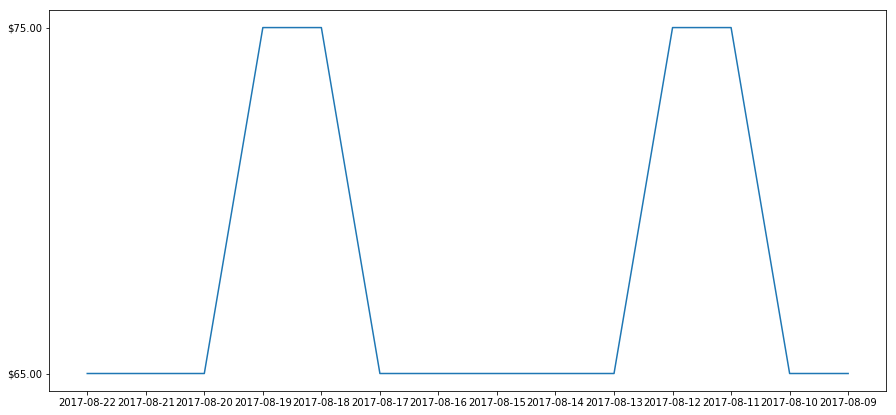

In [36]:
# 家賃の時系列プロット

listing_sample = boston_calendar[(boston_calendar.listing_id == 3075044) & (boston_calendar.available == 't')]

plt.figure(figsize=(15, 7))
plt.plot(listing_sample.date.values[:14], listing_sample.price.values[:14])

特定の曜日に10$上がってる？

In [37]:
listing_sample['price'] = listing_sample['price'].map(lambda x: float(x[1:]))
listing_sample['date'] = pd.to_datetime(listing_sample['date'])
listing_sample['weekday'] = listing_sample.date.dt.weekday
listing_sample['weekday_name'] = listing_sample.date.dt.weekday_name
listing_sample.head()

,listing_id,date,available,price,weekday,weekday_name
365,3075044,2017-08-22,t,65.0,1,Tuesday
366,3075044,2017-08-21,t,65.0,0,Monday
367,3075044,2017-08-20,t,65.0,6,Sunday
368,3075044,2017-08-19,t,75.0,5,Saturday
369,3075044,2017-08-18,t,75.0,4,Friday


In [38]:
listing_sample.groupby('weekday_name')['price'].mean()

weekday_name
Friday       75.0
Monday       65.0
Saturday     75.0
Sunday       65.0
Thursday     65.0
Tuesday      65.0
Wednesday    65.0
Name: price, dtype: float64

週末（金曜、土曜）が上がっている

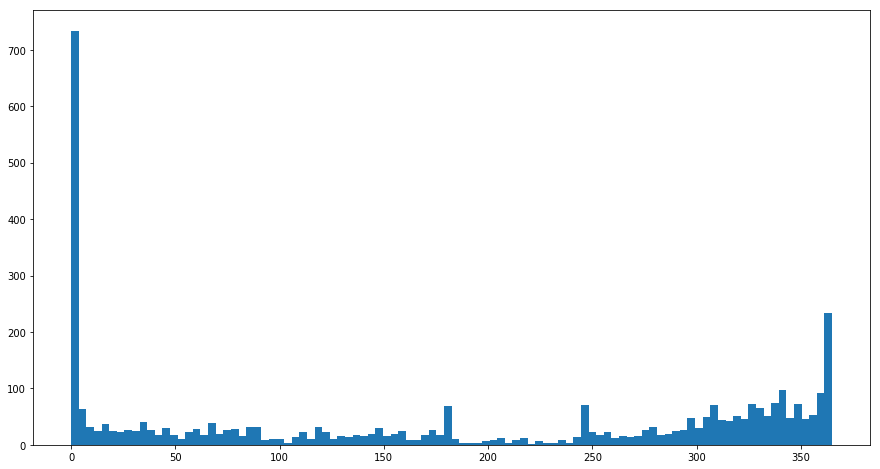

In [45]:
# カレンダーで貸し出し期間が少ない物件を探す

saled_days_count = boston_calendar.groupby('listing_id')['price'].count().reset_index()

plt.figure(figsize=(15, 8))
plt.hist(saled_days_count.price, 100)
plt.show()

売り出し日が少ない物件が多い

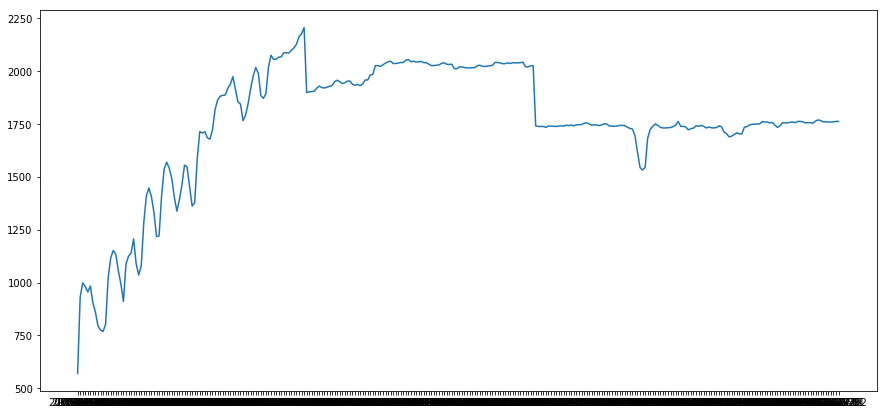

In [53]:
# 貸し出されている物件数 時系列プロット

saled_room_by_date = boston_calendar.groupby('date')['price'].count()

plt.figure(figsize=(15, 7))
plt.plot(saled_room_by_date.index[:300], saled_room_by_date.values[:300])

In [64]:
def transform_calendar(calendar_df):

    #calendar_df['price'] = calendar_df['price'].map(lambda x: float(x[1:]))

    calendar_df['date'] = pd.to_datetime(calendar_df['date'])
    calendar_df['weekday'] = calendar_df.date.dt.weekday
    calendar_df['weekday_name'] = calendar_df.date.dt.weekday_name
    
    return calendar_df

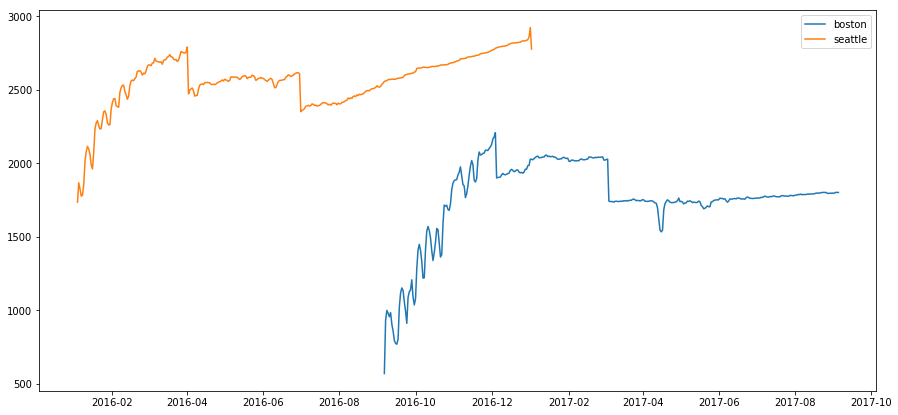

In [67]:
boston_calendar = transform_calendar(boston_calendar)
seattle_calendar = transform_calendar(seattle_calendar)

saled_room_by_date_boston = boston_calendar.groupby('date')['price'].count()
saled_room_by_date_seattle = seattle_calendar.groupby('date')['price'].count()

plt.figure(figsize=(15, 7))
plt.plot(saled_room_by_date_boston.index, saled_room_by_date_boston.values, label='boston')
plt.plot(saled_room_by_date_seattle.index, saled_room_by_date_seattle.values, label='seattle')
plt.legend()

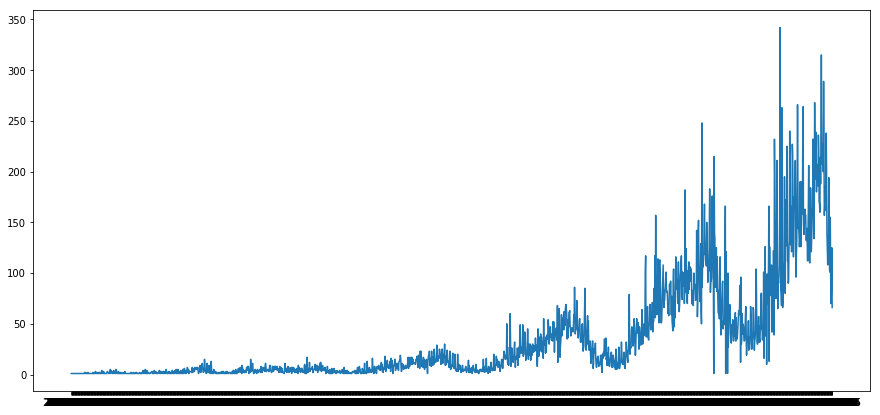

In [68]:
# レビュー数のトレンド

reviewed_by_date = boston_review.groupby('date')['reviewer_id'].count()

plt.figure(figsize=(15, 7))
plt.plot(reviewed_by_date.index, reviewed_by_date.values)

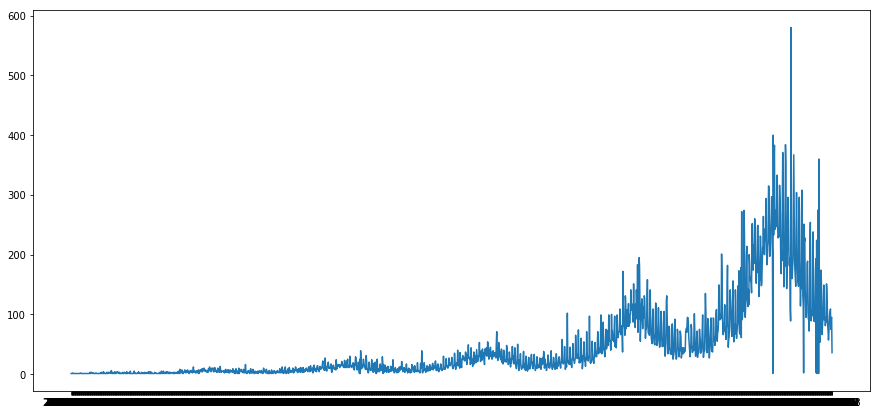

In [69]:
reviewed_by_date = seattle_review.groupby('date')['reviewer_id'].count()

plt.figure(figsize=(15, 7))
plt.plot(reviewed_by_date.index, reviewed_by_date.values)